In [41]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.patches as mpatches
import time

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import average_precision_score, precision_recall_curve

from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import collections

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt



from scipy import misc
import pymysql as mdb

%matplotlib notebook

# Reading Data

In [42]:
songs_df = pd.read_csv('spotify_data.csv')

In [43]:
songs_df.head(5)

,acousticness,danceability,energy,ind,instrumentalness,key,label,liveness,loudness,mode,song_id,song_name,speechiness,tempo,valence
0,0.1560,0.793,0.714,222,0.000000,7,1,0.1360,-7.562,1,02Ygu8lo3qSknRpcBnspso,Just Friends,0.1930,100.036,0.794
1,0.2720,0.783,0.430,47,0.000002,11,0,0.2540,-9.783,1,03ZFDJXHFi8dDSf2dmBNoR,Footprint,0.2830,82.066,0.192
2,0.7550,0.815,0.308,217,0.001040,5,1,0.1080,-10.956,1,04Fd2hmbDWV4Lc7OLarvBa,The Best Of Myself,0.0463,79.492,0.572
3,0.1820,0.654,0.739,53,0.000000,9,0,0.0646,-5.093,0,04wkQ3rrZMebfFN3t2DS7w,Light of You,0.0826,124.051,0.522
4,0.0073,0.826,0.790,212,0.000010,10,1,0.1220,-4.341,1,07s9NNOT0sZQp7TyolLLgu,Own It (feat. Ed Sheeran & Burna Boy),0.1260,104.032,0.377


In [44]:
song_names = list(songs_df["song_name"])
songs_df = songs_df.drop(columns=['ind','song_name', 'song_id'])

In [45]:
songs_df.describe()
#remove ind, song_name, song_id

,acousticness,danceability,energy,instrumentalness,key,label,liveness,loudness,mode,speechiness,tempo,valence
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,0.197484,0.635858,0.659269,0.027088,5.356436,0.739274,0.156967,-5.940611,0.633663,0.095565,118.673106,0.464918
std,0.227721,0.147750,0.181107,0.136970,3.709441,0.439757,0.114932,2.278152,0.482600,0.093680,28.104794,0.223869
min,0.000007,0.221000,0.057500,0.000000,0.000000,0.000000,0.024300,-16.996000,0.000000,0.023200,62.633000,0.037100
25%,0.032600,0.532000,0.536000,0.000000,1.000000,0.000000,0.090400,-6.938000,0.000000,0.041150,98.048000,0.290500
50%,0.106000,0.655000,0.671000,0.000000,6.000000,1.000000,0.114000,-5.659000,1.000000,0.057400,115.555000,0.464000
75%,0.279500,0.744000,0.795000,0.000017,8.000000,1.000000,0.179500,-4.589500,1.000000,0.106000,135.533000,0.621000
max,0.950000,0.965000,0.991000,0.922000,11.000000,1.000000,0.760000,-1.580000,1.000000,0.503000,205.272000,0.969000


In [46]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 12 columns):
acousticness        303 non-null float64
danceability        303 non-null float64
energy              303 non-null float64
instrumentalness    303 non-null float64
key                 303 non-null int64
label               303 non-null int64
liveness            303 non-null float64
loudness            303 non-null float64
mode                303 non-null int64
speechiness         303 non-null float64
tempo               303 non-null float64
valence             303 non-null float64
dtypes: float64(9), int64(3)
memory usage: 28.5 KB


<IPython.core.display.Javascript object>


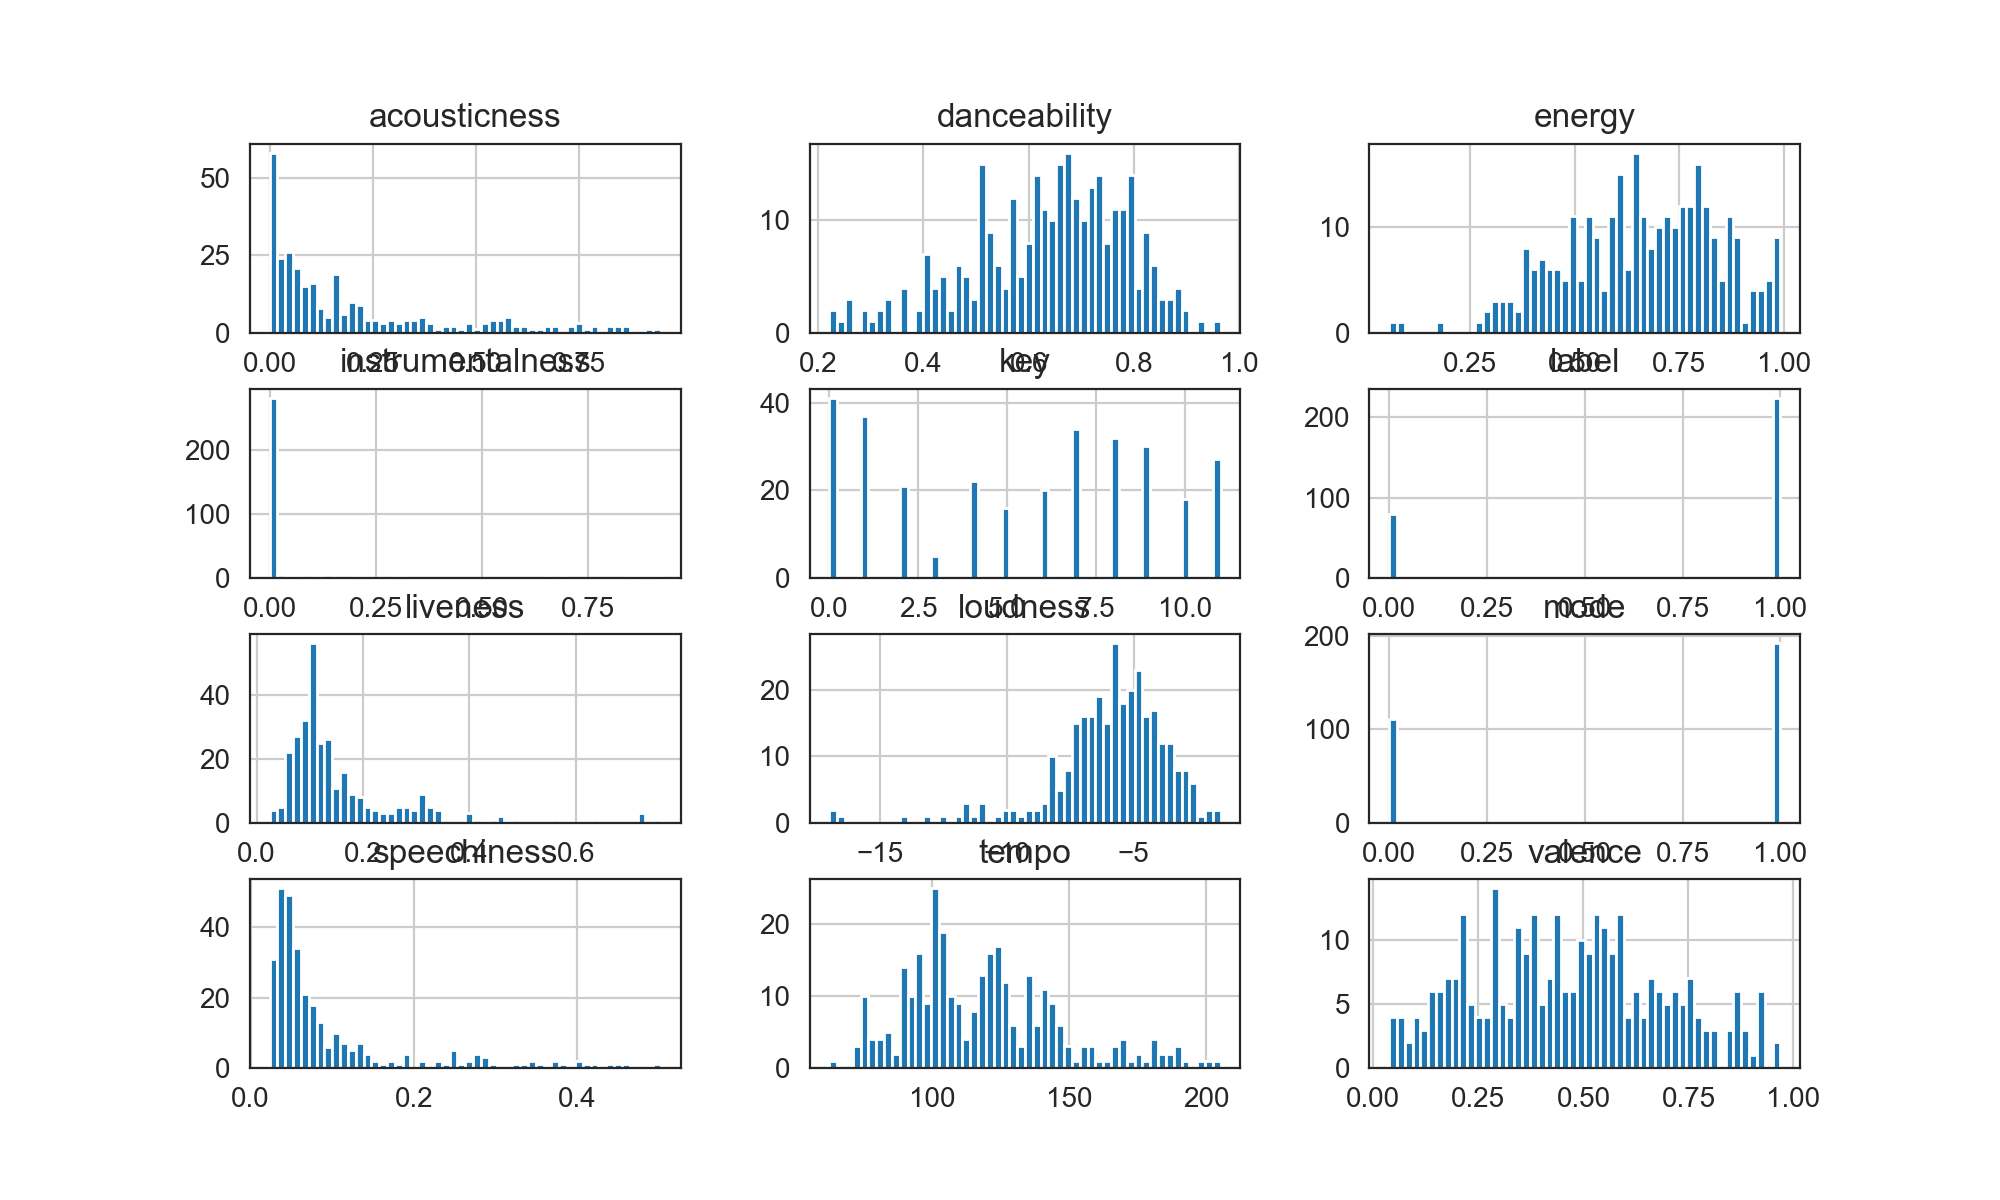

In [47]:
songs_df.hist(bins=50, figsize=(10,6))
plt.show()
#tail heavy - acousticness, liveness, speechiness, tempo

# Creating Train and Test Sets

We can see that in our tiny dataset, there is a huge imbalance with liked instances almost 3 times as many as the disliked instanced. To solve this problem, we will experiment with some data balancing techniques. 

In [48]:
X = songs_df.drop('label', axis=1)
y = songs_df['label']

In [49]:
# Seperating Test Set and Train Set

sss = StratifiedKFold(n_splits=7, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Visualizng our training data

In [50]:
cluster_features = ['acousticness', 'danceability', 'instrumentalness', 'energy', 'speechiness']
df_cluster = songs_df[cluster_features]
X_visualization = np.array(df_cluster)
scaler = StandardScaler()
scaler.fit(X_visualization)
X_visualization = scaler.transform(X_visualization)

<IPython.core.display.Javascript object>


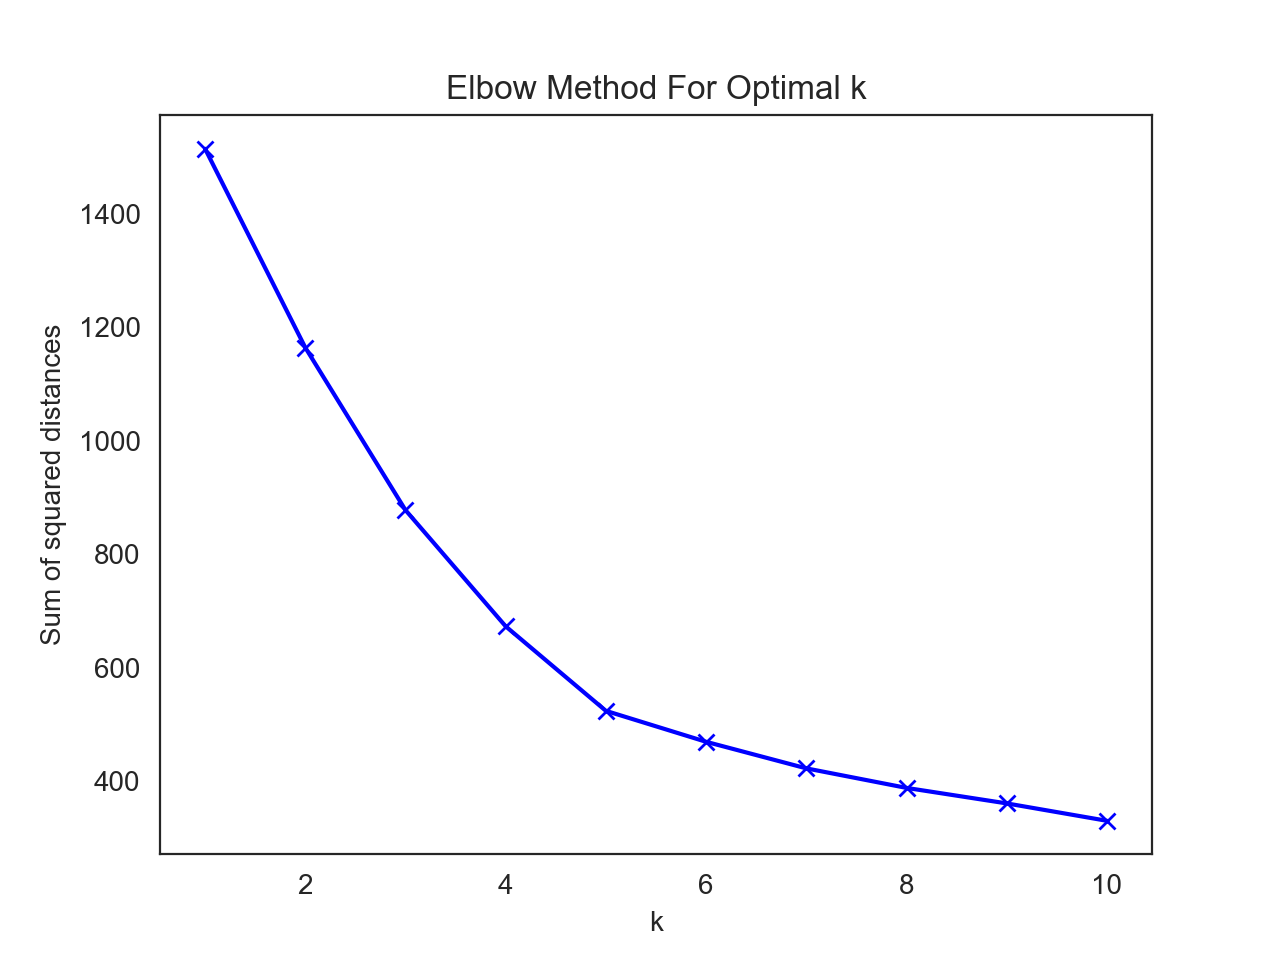

In [51]:
#Elbow method to determine k for k-means clustering

ss_dist = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', random_state=123)
    km = km.fit(X_visualization)
    ss_dist.append(km.inertia_)
plt.figure()
plt.plot(K, ss_dist, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

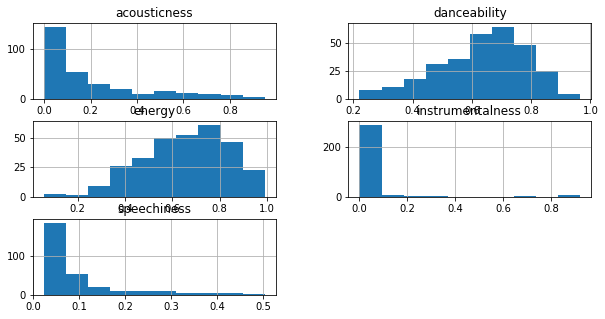

In [13]:
df_cluster.hist(figsize=(10,5))
plt.show()

In [52]:
num_clusters = 5 #elbow method shows an inflection point at 5
kmeanModel = KMeans(n_clusters=num_clusters, max_iter=10000, init='k-means++', random_state=123).fit(X_visualization)

### PCA

In [53]:
pca = PCA(n_components=3, random_state=123)
pca_results = pca.fit_transform(X_visualization)

In [54]:
print(pca.explained_variance_ratio_.sum())
pca.explained_variance_ratio_.cumsum()

0.7831039782515035


array([0.33723479, 0.58473983, 0.78310398])

In [55]:
df_pca_vis = pd.DataFrame({'Component': ['1','2','3'],'Indiv':pca.explained_variance_ratio_})
df_pca_vis['cum_sum'] = df_pca_vis['Indiv'].cumsum()
df_pca_vis

,Component,Indiv,cum_sum
0,1,0.337235,0.337235
1,2,0.247505,0.584740
2,3,0.198364,0.783104


<IPython.core.display.Javascript object>


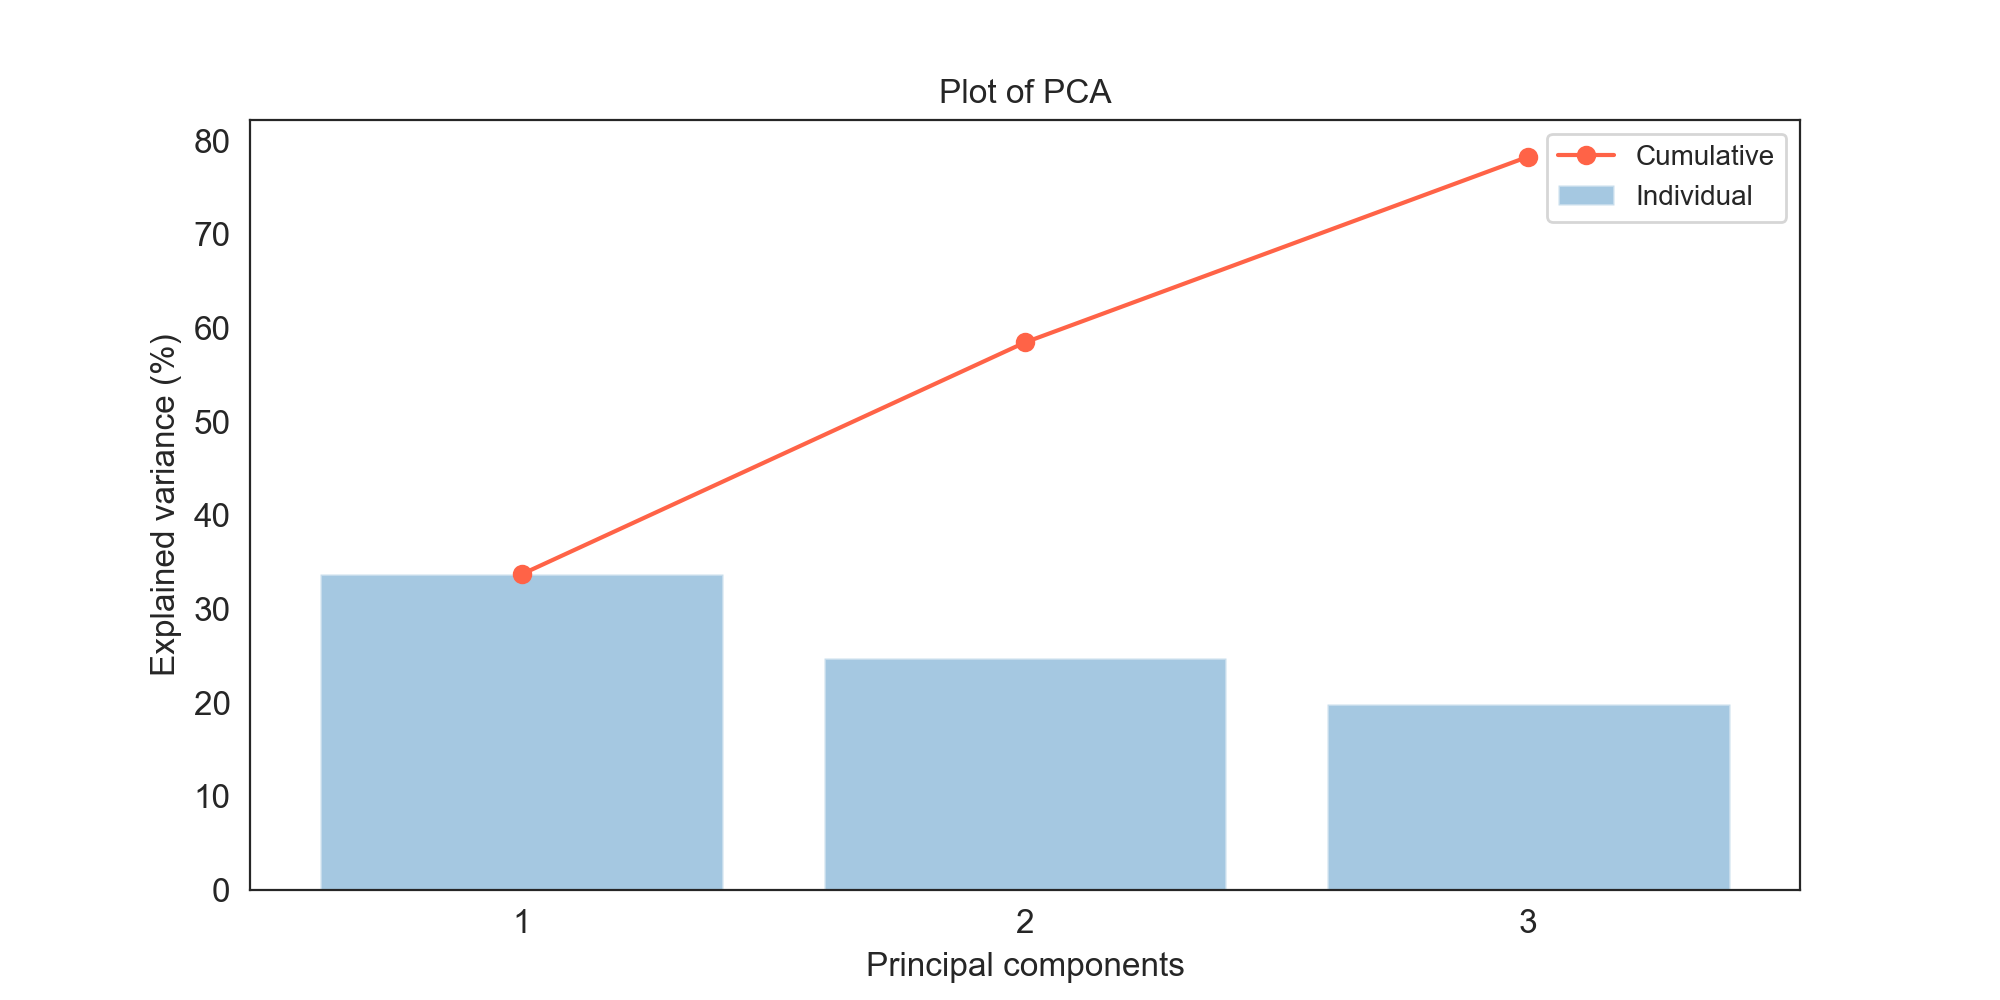

In [56]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, 
        label='Individual', axes=ax, alpha=0.4)
plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_.cumsum(), 
         label='Cumulative', color='tomato', axes=ax, marker='o')

ax.set_xticks(range(0,3))
ax.set_xticklabels(range(1,4), fontsize=12)
ax.set_yticklabels(range(0,90,10), fontsize=12)

plt.title('Plot of PCA', fontsize=12)
plt.ylabel('Explained variance (%)', fontsize=12)
plt.xlabel('Principal components', fontsize=12)
plt.legend()
plt.show()

In [19]:
df_pca = pd.DataFrame(pca_results)
df_pca.columns = ['PC1', 'PC2','PC3']
df_pca['label'] = kmeanModel.labels_
df_pca.head()

,PC1,PC2,PC3,label
0,-0.592116,-0.985549,0.582252,1
1,0.653108,-1.474898,1.670510,2
2,2.912636,-1.670916,-0.352346,3
3,-0.382810,-0.100743,-0.200124,1
4,-1.193964,-0.814881,-0.290141,1


<IPython.core.display.Javascript object>


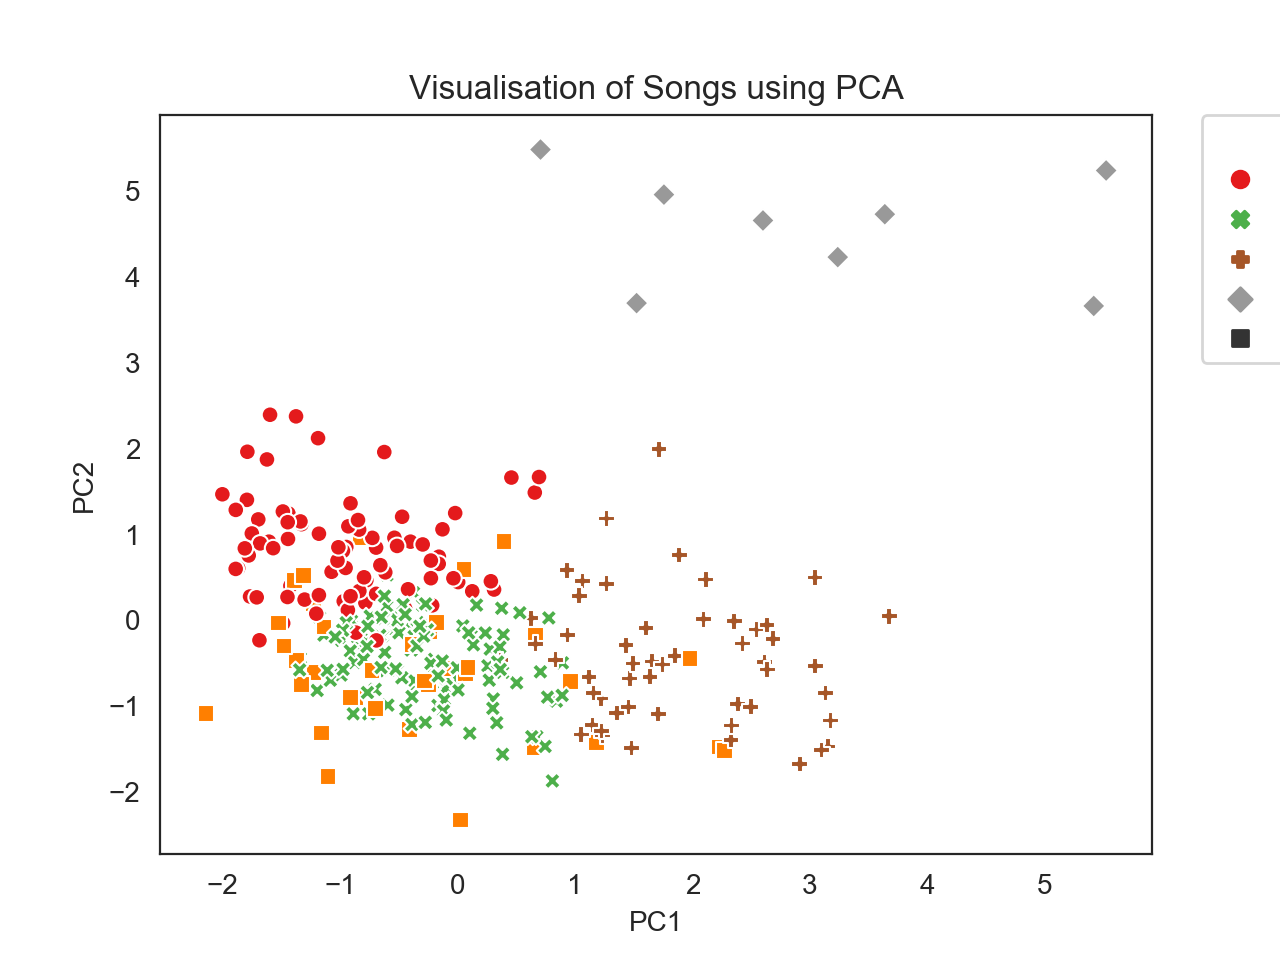

In [57]:
plt.figure()
sns.set_style('white')
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='label', style='label', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Visualisation of Songs using PCA')
plt.show()

<IPython.core.display.Javascript object>


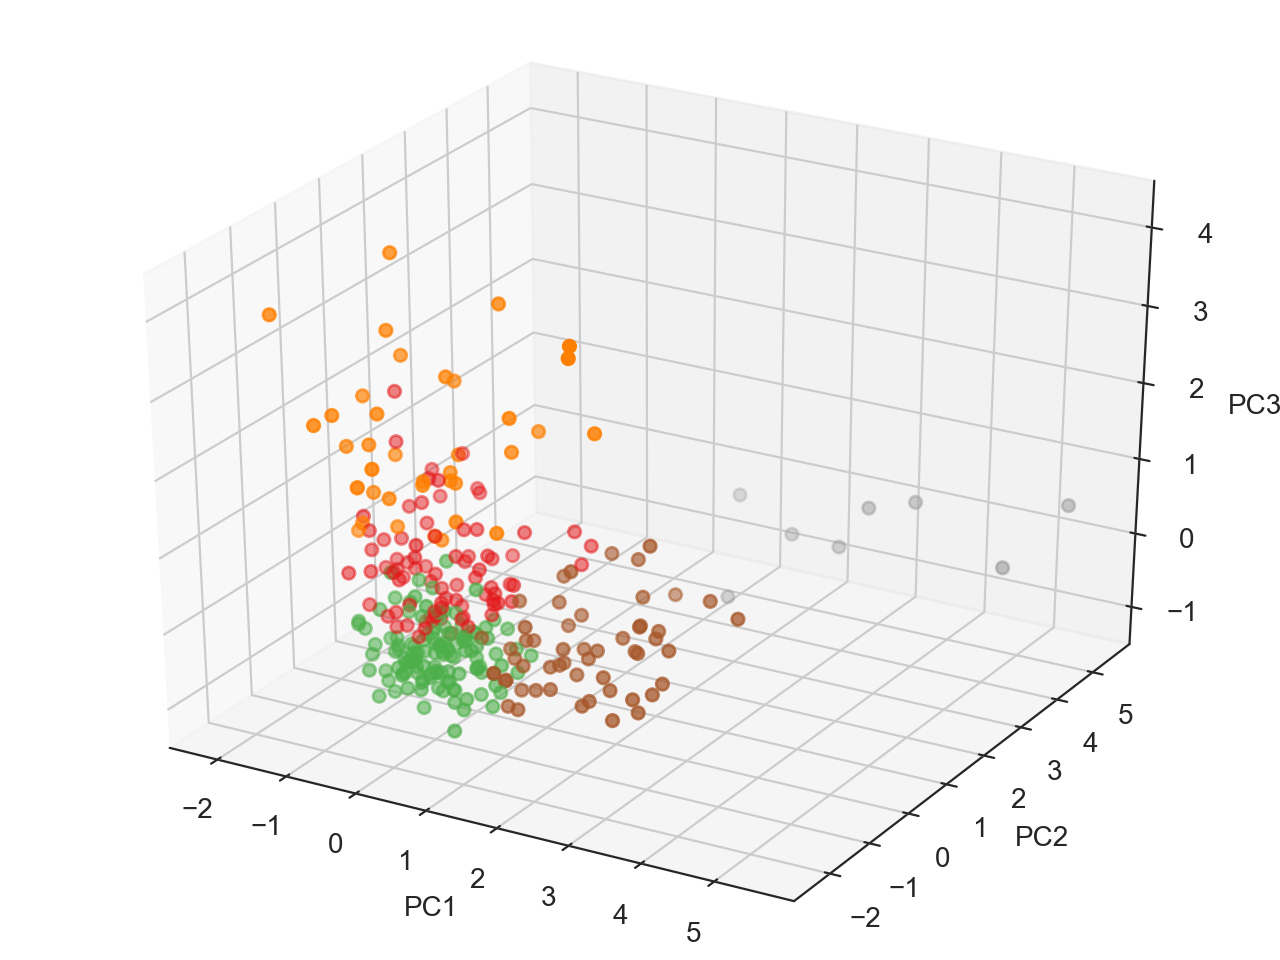

In [58]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'],
           c=df_pca['label'], cmap='Set1')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

### t-SNE 

In [59]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=5000, random_state=123, learning_rate=190)
tsne_results = tsne.fit_transform(X_visualization)

In [60]:
df_tsne = pd.DataFrame(tsne_results)
df_tsne.columns = ['D1', 'D2']
df_tsne['label'] = kmeanModel.labels_
df_tsne.head()

,D1,D2,label
0,-9.052760,-5.005731,1
1,-11.946675,-3.058383,2
2,9.159306,6.370327,3
3,-2.089687,-2.503705,1
4,0.154427,-7.679017,1


<IPython.core.display.Javascript object>


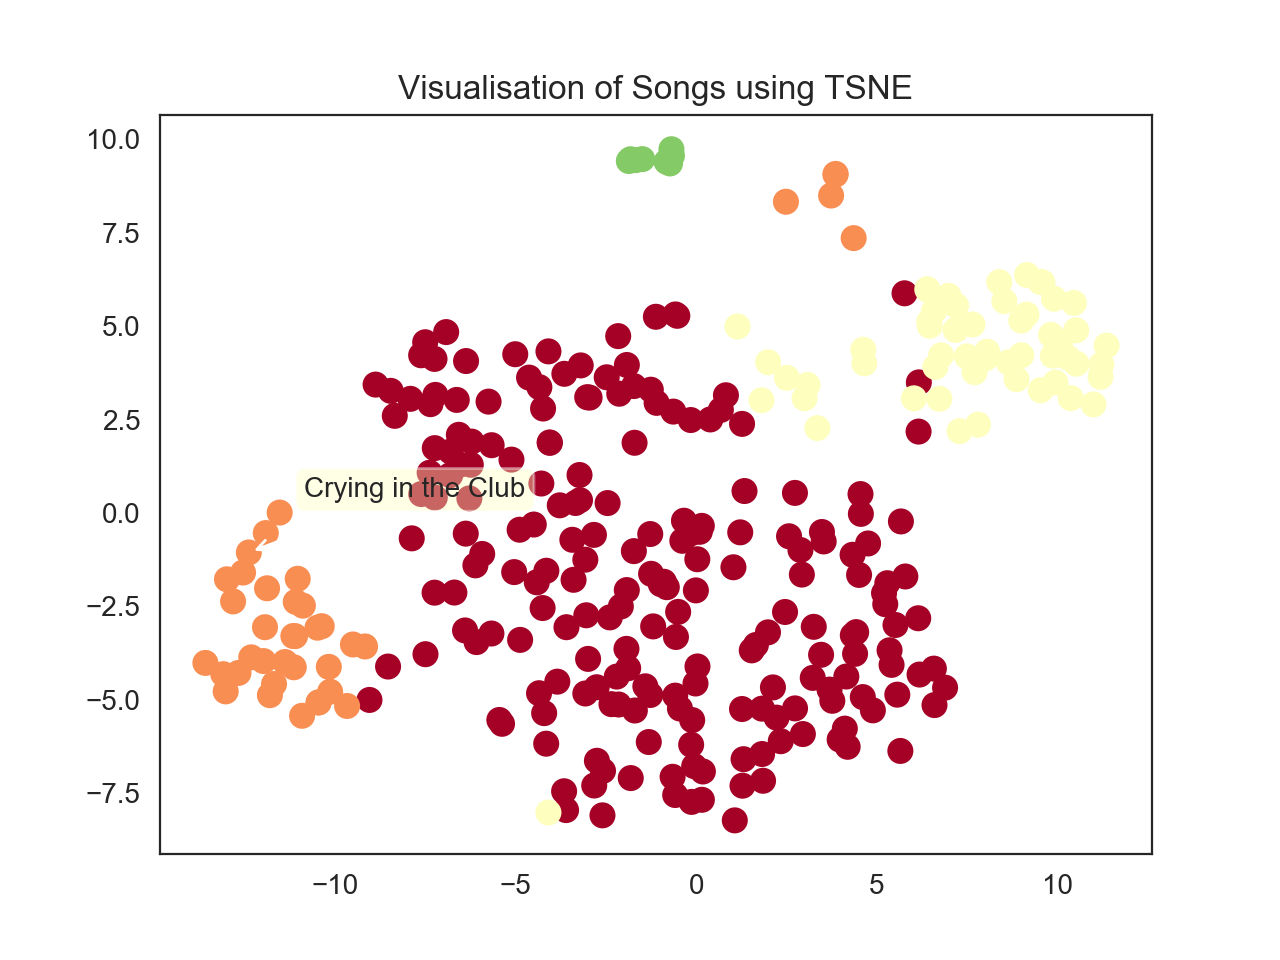

In [61]:
# visualizing the clusters by reducing the dimension of the data through t-SNE
# added the hover effect over the graph so you can see the name of the song for each data point in the graph

c = np.random.randint(1,5,size=len(song_names))

norm = plt.Normalize(1,5)
cmap = plt.cm.RdYlGn

fig,ax = plt.subplots()
sc = plt.scatter(df_tsne['D1'], df_tsne['D2'], c=df_tsne['label'], s=70, cmap=cmap, norm=norm)
plt.title('Visualisation of Songs using TSNE')
annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)


def hover(event):
    def update_annot(ind):

        pos = sc.get_offsets()[ind["ind"][0]]
        annot.xy = pos
        text = "{}".format(" ".join([song_names[n] for n in ind["ind"]]))
        annot.set_text(text)
        annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
        annot.get_bbox_patch().set_alpha(0.4)


    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
        

fig.canvas.mpl_connect("motion_notify_event", hover)
#plt.gcf().set_size_inches((12, 8)) 
plt.show();

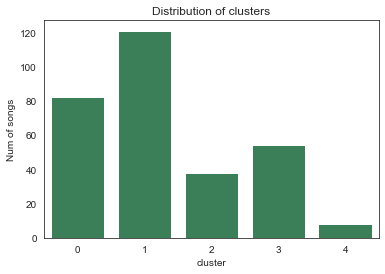

In [25]:
songs_df.loc[:,'cluster'] = kmeanModel.labels_
df_cluster_size = songs_df.groupby('cluster').size().reset_index(name='Num of songs')
plt.figure()
sns.barplot(data=df_cluster_size, x='cluster', y='Num of songs', color='seagreen')
plt.title('Distribution of clusters')
plt.show();

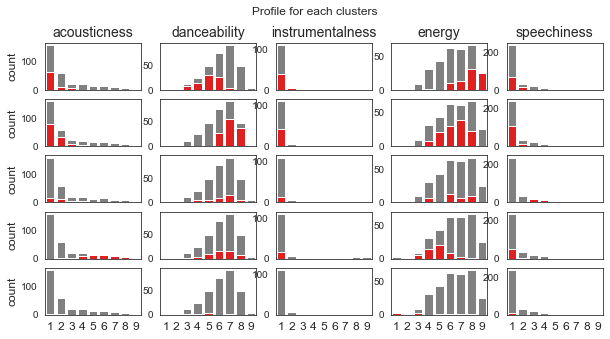

In [26]:
# set binning intervals of 0.1
bins = np.linspace(0,1,10)

# create subplots
num_features = len(cluster_features)
f, axes = plt.subplots(num_clusters, num_features, 
                       figsize=(10, 5), sharex='col')

# initialise 1st row. Representing cluster
row = 0
for cluster in np.sort(songs_df['cluster'].unique()):
#     filter cluster dataframe and reset column to 0 for 1st plot for the cluster
    df_cluster = songs_df[songs_df['cluster'] == cluster]
    col = 0
    
    for feature in cluster_features:
#         create binned count for all recent df and clustered df
        rec_grp = songs_df.groupby(pd.cut(songs_df[feature], bins)).size().reset_index(name='count')
        cluster_grp = df_cluster.groupby(pd.cut(df_cluster[feature], bins)).size().reset_index(name='count')
        
#         plot overall distribution and cluster distribution on the ax
        sns.barplot(data=rec_grp, x=feature, y='count', 
                    color='grey', ax=axes[row, col])
        sns.barplot(data=cluster_grp, x=feature, y='count', 
                    color='red', ax=axes[row, col])
        
#         configure ax
        axes[row, col].set_xlabel('')
        axes[row, col].set_xticklabels(range(1,10), fontsize=12)
        if col > 0:
            axes[row, col].set_ylabel('')
        else:
            axes[row, col].set_ylabel('count', fontsize=12)
        if row == 0:
            axes[row, col].set_title(feature, fontsize=14)        
        col += 1
    row += 1
    
f.suptitle('Profile for each clusters')
    
plt.show()

In [27]:
# Turn into an array
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [28]:
# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(y_train, return_counts=True)
test_unique_label, test_counts_label = np.unique(y_test, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(y_train))
print(test_counts_label/ len(y_test))

----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.26153846 0.73846154]
[0.25581395 0.74418605]


In [29]:
# Feature Scaling

from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler

preprocess_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
])

X_train = preprocess_pipeline.fit_transform(X_train)

train_mean = preprocess_pipeline.steps[0][1].mean_
train_std = preprocess_pipeline.steps[0][1].var_ ** (1/2)

X_test = ((X_test - train_mean) / train_std)

In [30]:
print('Length of X (train): {} | Length of y (train): {}'.format(len(X_train), len(y_train)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(X_test), len(y_test)))

Length of X (train): 260 | Length of y (train): 260
Length of X (test): 43 | Length of y (test): 43


In [31]:
# List to append the score and then find the average
accuracy = []
precision = []
recall = []
f1 = []
auc = []

In [32]:
# Classifiers

# Random Forest
rand_for_sm = RandomForestClassifier()
rand_for_params = {"max_depth": [4, 3, None],
              "max_features": [2, 3, 11],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
rand_for = RandomizedSearchCV(rand_for_sm, rand_for_params, n_iter=4)


# Logistic Regression
log_reg_sm = LogisticRegression()
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
log_reg = RandomizedSearchCV(log_reg_sm, log_reg_params, n_iter=4)

# Gradient Boosting 

gr_boo_sm = GradientBoostingClassifier()
gr_boo_params = {"max_depth": [4, 3, None],
              "max_features": [2, 3, 11],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              #"bootstrap": [True, False],
              "criterion": ["friedman_mse", "mse", "mae"]}
gr_boo = RandomizedSearchCV(gr_boo_sm, gr_boo_params, n_iter=4)

In [33]:
def cv_smote(classifier):
    #print()
    #print(classifier.estimator,'\n')
    # Implementing SMOTE Technique 
    # Cross Validating the right way

    for train, test in sss.split(X_train, y_train):
        # SMOTE happens during Cross Validation not before
        pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), classifier)
        model = pipeline.fit(X_train[train], y_train[train])
        best_est = classifier.best_estimator_
        prediction = best_est.predict(X_train[test])

        accuracy.append(pipeline.score(X_train[test], y_train[test]))
        precision.append(precision_score(y_train[test], prediction))
        recall.append(recall_score(y_train[test], prediction))
        f1.append(f1_score(y_train[test], prediction))
        auc.append(roc_auc_score(y_train[test], prediction))

    print('---' * 20)
    print()
    print("accuracy: {}".format(round(np.mean(accuracy),3)))
    print("precision: {}".format(round(np.mean(precision),3)))
    print("recall: {}".format(round(np.mean(recall),3)))
    print("f1: {}".format(round(np.mean(f1),3)))
    print()
    print('---' * 20)
    
    return best_est

In [34]:
classifiers_list = []

print("Results for RandomForestClassifier")
rand_for_est = cv_smote(rand_for)
classifiers_list.append(("Random Forest Classifier",rand_for_est))

print("Results for LogisticRegression")
log_reg_est = cv_smote(log_reg)
classifiers_list.append(("Logistic Regression Classifier",log_reg_est))

print("Results for GradientBoostingClassifier")
gr_boo_est = cv_smote(gr_boo)
classifiers_list.append(("Gradient Bossting Classifier",gr_boo_est))


Results for RandomForestClassifier
------------------------------------------------------------

accuracy: 0.716
precision: 0.818
recall: 0.793
f1: 0.804

------------------------------------------------------------
Results for LogisticRegression
------------------------------------------------------------

accuracy: 0.655
precision: 0.807
recall: 0.696
f1: 0.743

------------------------------------------------------------
Results for GradientBoostingClassifier
------------------------------------------------------------

accuracy: 0.68
precision: 0.81
recall: 0.739
f1: 0.768

------------------------------------------------------------


In [35]:
def print_report(classifier):
    labels = ['Disliked', 'Liked']
    smote_prediction = classifier.predict(X_test)
    print("Result for: {}".format(str(classifier)))
    print(classification_report(y_test, smote_prediction, target_names=labels))

for classifier in classifiers_list:
    print_report(classifier[1])

Result for: RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
              precision    recall  f1-score   support

    Disliked       0.36      0.36      0.36        11
       Liked       0.78      0.78      0.78        32

    accuracy                           0.67        43
   macro avg       0.57      0.57      0.57        43
weighted avg       0.67      0.67      0.67        43

Result for: LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                

In [36]:
'''# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(ratio='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)

# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

# Support Vector Classifier
SupportVC = SVC()
SupportVC.fit(Xsm_train, ysm_train)

# Logistic Regression Classifier
LR = LogisticRegression()
LR.fit(Xsm_train, ysm_train)

# Gradient Boosting Classifier 

GR = GradientBoostingClassifier()
GR.fit(Xsm_train, ysm_train)'''

"# SMOTE Technique (OverSampling) After splitting and Cross Validating\nsm = SMOTE(ratio='minority', random_state=42)\n# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)\n\n\n# This will be the data were we are going to \nXsm_train, ysm_train = sm.fit_sample(X_train, y_train)\n\n# We Improve the score by 2% points approximately \n# Implement GridSearchCV and the other models.\n\n# Support Vector Classifier\nSupportVC = SVC()\nSupportVC.fit(Xsm_train, ysm_train)\n\n# Logistic Regression Classifier\nLR = LogisticRegression()\nLR.fit(Xsm_train, ysm_train)\n\n# Gradient Boosting Classifier \n\nGR = GradientBoostingClassifier()\nGR.fit(Xsm_train, ysm_train)"

In [37]:
# Baseline Prediction

baseline = np.random.randint(0,2,43)

unique, counts = np.unique(baseline == y_test, return_counts=True)
dict(zip(unique, counts))

{False: 16, True: 27}

In [38]:
y_ens = []
for classifier in classifiers_list:
    y_pred = classifier[1].predict(X_test)
    y_ens.append(y_pred)
    
    unique, counts = np.unique(y_pred == y_test, return_counts=True)
    print(classifier[0], " : ",dict(zip(unique, counts)))

Random Forest Classifier  :  {False: 14, True: 29}
Logistic Regression Classifier  :  {False: 21, True: 22}
Gradient Bossting Classifier  :  {False: 9, True: 34}


In [39]:
from scipy import stats

m = stats.mode(y_ens)

In [40]:
unique, counts = np.unique(m[0] == y_test, return_counts=True)
print(classifier[0], " : ",dict(zip(unique, counts)))

Gradient Bossting Classifier  :  {False: 13, True: 30}
